In [1]:
import pickle
import numpy as np
import random
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

from numpy import newaxis
from scipy import ndimage
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten

########## CONSTANTS #############
classes_number       = 43
l_rate               = 0.001
epochs               = 20
batch_size           = 150

In [2]:
################################# LOAD DATA SET ########################################
def load_data_set():                         
    training_file       = 'traffic-signs-data/train.p'
    testing_file        = 'traffic-signs-data/test.p'
    validation_file     = 'traffic-signs-data/valid.p'

    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
    with open(validation_file, mode='rb') as f:
        valid = pickle.load(f) 
    
    return train['features'], train['labels'], test['features'], test['labels'], valid['features'], valid['labels']

In [3]:
########################## PRINT DATA SET INFORMATION ##################################
def print_data_info(y_train,y_test,X_train,y_valid): 
    print("Number of training examples    =", y_train.shape[0])
    print("Number of testing examples     =", y_test.shape[0])
    print("Number of validation examples  =", y_valid.shape[0])
    print("Image data shape               =", X_train[0].shape)
    print("Number of classes              =", np.unique(y_train).shape[0])

In [4]:
%matplotlib inline
########################## VISUALIZE SAMPLE DATA #######################################
def show_sample_data(X_train):       
    indx = np.arange(X_train.shape[0])
    np.random.shuffle(indx)
    x = 4 
    y = 2
   
    plt.figure(figsize=(12, 8))
    for i in range(x*y):
        plt.subplot(x, y, i+1)
        plt.imshow(X_train[indx[i]],cmap='gray')
    plt.show()

In [5]:
%matplotlib inline
########################## HISTOGRAM OF TRAIN DATA  ###################################
def show_data_set_hist(y_train):      
    plt.hist(y_train, 42, facecolor='red', alpha=0.75)

    plt.xlabel('Training Classes')
    plt.ylabel('Number of Trainging Samples')
    plt.title('Training Samples Distribution')
    plt.grid(True)

Number of training examples    = 34799
Number of testing examples     = 12630
Number of validation examples  = 4410
Image data shape               = (32, 32, 3)
Number of classes              = 43


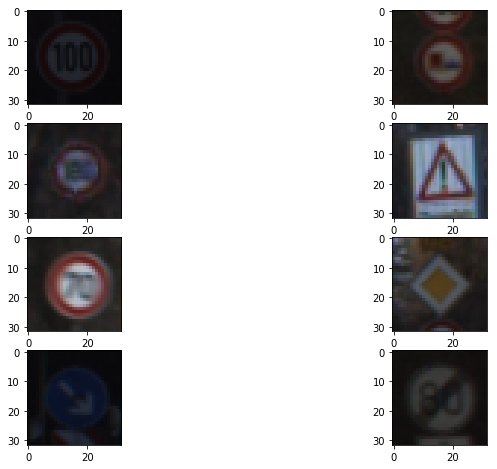

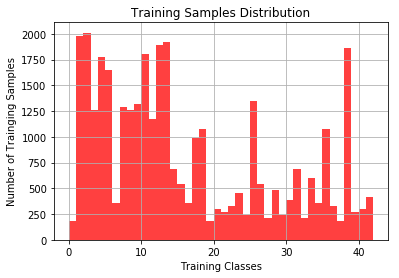

In [6]:
X_train, y_train, X_test, y_test, X_valid, y_valid = load_data_set()
print_data_info(y_train, y_test, X_train, y_valid)
show_sample_data(X_train)
show_data_set_hist(y_train)

In [7]:
########################## NORMALIZE THE DATA BETWEEN 0.1 AND 0.9  #####################
def normalize(data):       
    return data / 255 * 0.8 + 0.1

############################## EQUALIZE HISTOGRAM WITH CLAHE ###############################
def hist_equalize(img):
    clahe = cv2.createCLAHE()
    return clahe.apply(img)

############################## CONVERT DATA TO GRAYSCALE ###############################
def preprocess(data):     
    gray_images = []
    for image in data:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_images.append(hist_equalize(gray)) 
    return np.array(gray_images)

In [8]:
############################## ROTATE IMAGES THROUGH VARIOUS ANGLES ###############################
def data_set_augument(X,y):
    pics_in_class = np.bincount(y)
    mean_pics     = int(np.mean(pics_in_class))
    min_desired   = int(mean_pics)
    angles        = [-10, 10, -15, 15, -20, 20]
    for i in range(len(pics_in_class)):
        if pics_in_class[i] < min_desired:
            new_wanted = min_desired - pics_in_class[i]
            picture = np.where(y == i)
            more_X = []
            more_y = []
        
            for num in range(new_wanted):     
                more_X.append(ndimage.rotate(X[picture][random.randint(0,pics_in_class[i] - 1)], random.choice(angles), reshape=False))
                more_y.append(i)
            
            X = np.append(X, np.array(more_X), axis=0)
            y = np.append(y, np.array(more_y), axis=0)
    return X,y,min_desired     

### Question 1/ Question 2 
_Describe how you preprocessed the data. Why did you choose that technique?Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
First of all I decided to convert all images in data set to grayscale. According to ,Pierre Sermanet and Yann LeCun paper about Traffic Sign Recognition, 3 channel images doesn't give huge accuracy differences.
Second step was applying Contrast Limited Adaptive Histogram Equalization. Dataset is very unbalanced. The images differ significantly in terms of contrast and brightness. Histogram equalization should help in feature extraction
Third step was normalizing dataset. So I scaled images from [0,255] range to [0.1,0.9].
Last step was extending training dataset. The amount of data is also very unbalanced. Some classes are represented to significantly lower extent than the others. I extend data set by rotating images through a different angles. These gives be about 10000 additional images in training set.

Preprocessing training data...


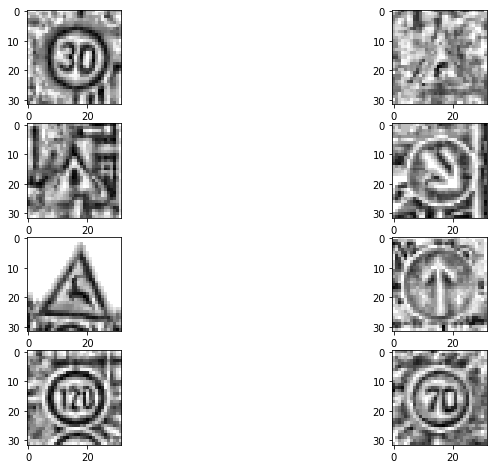

Finished preprocessing training data.

Preprocessing testing data...
Finished preprocessing testing data.

Preprocessing validation data...
Finished preprocessing validation data.

Generating new data...
Additional data generated. Any classes lacking data now have 809 pictures.
The updated number of training examples = 46714

Training set   (46714, 32, 32, 1)
Validation set (4410, 32, 32, 1)
Test set       (12630, 32, 32, 1)


In [9]:
print('Preprocessing training data...')
X_train_preprocessed = preprocess(X_train)

show_sample_data(X_train_preprocessed)

X_train_preprocessed = X_train_preprocessed[..., newaxis]
X_train_preprocessed = normalize(X_train_preprocessed) 
print('Finished preprocessing training data.')
print('')

print('Preprocessing testing data...')
X_test = preprocess(X_test)
X_test = X_test[..., newaxis]
X_test = normalize(X_test) 
print('Finished preprocessing testing data.')
print('')

print('Preprocessing validation data...')
X_valid = preprocess(X_valid)
X_valid = X_valid[..., newaxis]
X_valid = normalize(X_valid) 
print('Finished preprocessing validation data.')
print('')

print('Generating new data...')
X_train_extended, y_train_extended,min_desired = data_set_augument(X_train_preprocessed,y_train)
print('Additional data generated. Any classes lacking data now have', min_desired, 'pictures.')

print("The updated number of training examples =",  len(X_train_extended))
print('')

X_train_extended, y_train_extended = shuffle(X_train_extended, y_train_extended)
print('Training set  ', X_train_extended.shape)
print('Validation set', X_valid.shape)
print('Test set      ', X_test.shape)


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._

**Answer:**
I decided to use a deep neural network classifier as a model, which was inspired by LeNet-5. It is fairly simple and has 4 layers: 2 convolutional layers for feature extraction and two fully connected layer as a classifier. I am using Xavier initializer, which automatically determines the scale of initialization based on the layers’ dimensions, hence there are less parameter we need to experiment with.

**1st Convolutional Layer**
_Shape = [5,5,1,32]_
The first layer is fed the 32x32x1 image. Input image was convolved using 5x5 kernel. The result was added with a bias vector and putted through ReLU activation function. Then, I applied to the result max pooling operator using kernal of [1,2,2,1] and a stride of [1,2,2,1]. Additionaly to get slightly more accuracy I applied Local Response Normalization

**2nd Convolutional Layer**
_Shape = [5,5,32,64]_
The second convolutional layer is identical to the first, with one main exceptions. Second layer is fed the output of the first convolutional layer.

**1st Fully Connected Layer**
_Shape = [1600,800]_
The output of the second convolutional layer is reshaped and multiplied by a weight matrix. The result of this multiplication is added to a bias vector, and that summation is passed through the ReLU activation function. Also dropout regularization with 0.5 probability was applied to prevent overfitting.

**2nd Fully Connected Layer**
_Shape = [800,300]_
The second fully connected layer is identical to first one.

**3nd Fully Connected Layer**
_Shape = [300,43]_
The network concludes by multiplying the result of the 2st fully connected layer with a weight matrix, adding a bias.


In [10]:
def neural_network(x):    
    c1_weight   = tf.get_variable('cweights1',shape = [5, 5, 1, 32],  initializer  = tf.contrib.layers.xavier_initializer())
    c2_weight   = tf.get_variable('cweights2',shape = [5, 5, 32, 64], initializer  = tf.contrib.layers.xavier_initializer())  
    c1_bias     = tf.get_variable('cbiases1', shape = [32], initializer  = tf.constant_initializer(0.0))                           
    c2_bias     = tf.get_variable('cbiases2', shape = [64], initializer  = tf.constant_initializer(0.0))                                                                                   
                                  
    conv_layer1 = tf.nn.conv2d(x, c1_weight, strides=[1, 1, 1, 1], padding='VALID') + c1_bias
    conv_layer1 = tf.nn.relu(conv_layer1)
    pool1       = tf.nn.lrn(tf.nn.max_pool(conv_layer1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID'))
        
    conv_layer2 = tf.nn.conv2d(pool1, c2_weight, strides=[1, 1, 1, 1], padding='VALID') + c2_bias
    conv_layer2 = tf.nn.relu(conv_layer2)
    pool2       = tf.nn.lrn(tf.nn.max_pool(conv_layer2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID'))
    
    flat        = tf.contrib.layers.flatten(pool2)

    fc1_weight  = tf.get_variable('fweights1',shape = [1600, 800],  initializer  = tf.contrib.layers.xavier_initializer())                             
    fc1_bias    = tf.get_variable('fbiases1', shape = [800], initializer  = tf.constant_initializer(0.0))                             
    
    fc1         = tf.matmul(flat, fc1_weight) + fc1_bias  
    fc1         = tf.nn.relu(fc1)
    fc1         = tf.nn.dropout(fc1, 0.5)

    fc2_weight  = tf.get_variable('fweights2',shape = [800, 300],  initializer  = tf.contrib.layers.xavier_initializer())                                  
    fc2_bias    = tf.get_variable('fbiases2', shape = [300], initializer  = tf.constant_initializer(0.0))             
    fc2         = tf.matmul(fc1, fc2_weight) + fc2_bias
    fc2         = tf.nn.relu(fc2)
    fc2         = tf.nn.dropout(fc2, keep_prob)
    
    fc3_weight  = tf.get_variable('fweights3',shape = [300, 43],  initializer  = tf.contrib.layers.xavier_initializer())
    fc3_bias    = tf.get_variable('fbiases3', shape = [43], initializer  = tf.constant_initializer(0.0))
    logits      = tf.matmul(fc2, fc3_weight) + fc3_bias
    
    return logits

In [11]:
x             = tf.placeholder(tf.float32, (None, 32, 32, 1))
y             = tf.placeholder(tf.int32, (None))
keep_prob     = tf.placeholder(tf.float32)
target_output = tf.one_hot(y, 43)

In [12]:
prediction         = neural_network(x)
cross_entropy      = tf.nn.softmax_cross_entropy_with_logits(logits = prediction, labels = target_output)
loss_operation     = tf.reduce_mean(cross_entropy)
optimizer          = tf.train.AdamOptimizer(learning_rate = l_rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(target_output, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [13]:
def evaluate(x, y, keep_prob, X_data, y_data):
    num_examples         = len(X_data)
    total_accuracy       = 0
    sess                 = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy         =  sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 1.0})
        total_accuracy   += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [14]:
def train_net(x_place, y_place, prop_place, X, y, X_valid, y_valid, saver, save_file):
   
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X)
    
        print("Training...")
        print()
        for i in range(epochs):
            X_train, y_train = shuffle(X, y)
            for offset in range(0, num_examples, batch_size):
                end = offset + batch_size
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                loss = sess.run(training_operation, feed_dict={x_place: batch_x, y_place: batch_y, prop_place : 0.5})
            
            validation_accuracy = evaluate(x_place,y_place,prop_place,X_valid, y_valid)
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()
        
        saver.save(sess, save_file)
        print('Trained Model Saved.')

In [15]:
save_file = 'traffic-signs-data/train_model.ckpt'
saver     = tf.train.Saver()
train_net(x,y,keep_prob,X_train_extended, y_train_extended, X_valid, y_valid,saver,save_file)

Training...

EPOCH 1 ...
Validation Accuracy = 0.886

EPOCH 2 ...
Validation Accuracy = 0.934

EPOCH 3 ...
Validation Accuracy = 0.943

EPOCH 4 ...
Validation Accuracy = 0.956

EPOCH 5 ...
Validation Accuracy = 0.962

EPOCH 6 ...
Validation Accuracy = 0.965

EPOCH 7 ...
Validation Accuracy = 0.961

EPOCH 8 ...
Validation Accuracy = 0.965

EPOCH 9 ...
Validation Accuracy = 0.964

EPOCH 10 ...
Validation Accuracy = 0.967

EPOCH 11 ...
Validation Accuracy = 0.969

EPOCH 12 ...
Validation Accuracy = 0.973

EPOCH 13 ...
Validation Accuracy = 0.967

EPOCH 14 ...
Validation Accuracy = 0.966

EPOCH 15 ...
Validation Accuracy = 0.971

EPOCH 16 ...
Validation Accuracy = 0.971

EPOCH 17 ...
Validation Accuracy = 0.971

EPOCH 18 ...
Validation Accuracy = 0.967

EPOCH 19 ...
Validation Accuracy = 0.970

EPOCH 20 ...
Validation Accuracy = 0.973

Trained Model Saved.


In [16]:
# Launch the model on the test data
with tf.Session() as sess:
    saver.restore(sess, 'traffic-signs-data/train_model.ckpt')
    test_accuracy = sess.run(accuracy_operation, feed_dict={x: X_test, y: y_test, keep_prob : 1.0})
print('Test Accuracy: {}'.format(test_accuracy))

Test Accuracy: 0.952414870262146


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_

**Answer:**
The CNN was trained with the Adam optimizer, batch size = 150 images, initial learning rate was 0.001. The model was trained for 20 epochs.

Variables were initialized with using of a Xavier initializer, which automatically determines the scale of initialization based on the layers dimensions, hence there are less parameter we need to experiment with. Learning rate was finetuned by try and error process.

Traffic sign classes were coded into one-hot encodings.

### Question 5

_What approach did you take in coming up with a solution to this problem?_

**Answer:**
It was a trial and error process, but all steps were inspired by scientific papers: LeCun, Alex Krizhevsky, Google 
As it is an image classification problem, convolutional layers were used as it is common in modern image classification systems as reduce computation (as compared to classical neural network with only fc layers).
Most challenging was to pick out size of kernels and depth of feature maps in conv layers. Final architecture and shape of feature maps depends in my case on experience and luck. Of course using well known technics to prevent overfitting helps to get satisfying results.

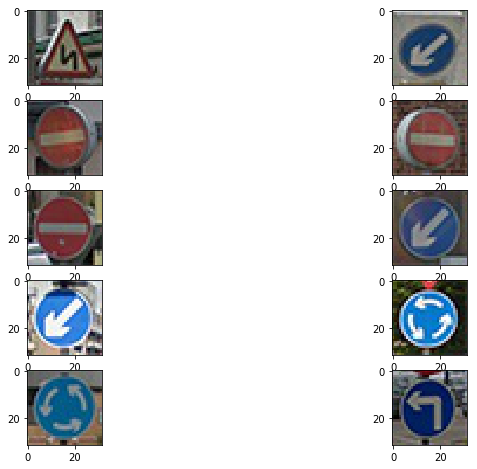

In [11]:
### Load the images and plot them here.
from skimage import io
test_imgs = np.uint8(np.zeros((10,32,32,3)))
for i in range(1,11):
    image = io.imread('test_images/test{}.jpg'.format(str(i)))
    test_imgs[i-1] = image

test_img_data = test_imgs.reshape((-1, 32, 32, 3)).astype(test_imgs[0].dtype)

plt.figure(figsize=(12, 8))
for i in range(10):
    plt.subplot(5, 2,i+1)
    plt.imshow(test_imgs[i])
plt.show()

In [12]:
gray_images = []
for image in test_img_data:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_images.append(gray) 
test_img_data = np.array(gray_images)
test_img_data = test_img_data[..., newaxis]
test_img_data = test_img_data / 255 * 0.8 + 0.1

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._

**Answer:**

There are 10 real traffic signs found in internet. I choose images of the same class to see if net can predict images with different contrast or quality for example slightly rotated "no entry" sign.

In [13]:
x           = tf.placeholder(tf.float32, (None, 32, 32, 1))
keep_prob   = tf.placeholder(tf.float32)
prediction  = neural_network(x)
softmax     = tf.nn.softmax(logits = prediction)

with tf.Session() as sess:
    saver     = tf.train.Saver()
    saver.restore(sess, 'traffic-signs-data/train_model.ckpt')
    pred_vals = sess.run(prediction, feed_dict={x: test_img_data, keep_prob : 1.0})
    prob      = sess.run(softmax, feed_dict={x: test_img_data, keep_prob : 1.0}) 
    top_k     = sess.run(tf.nn.top_k(prob, 5, sorted=True))

In [14]:
import csv
signs_class=[]
with open('signnames.csv', 'rt') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        signs_class.append((row['SignName']))

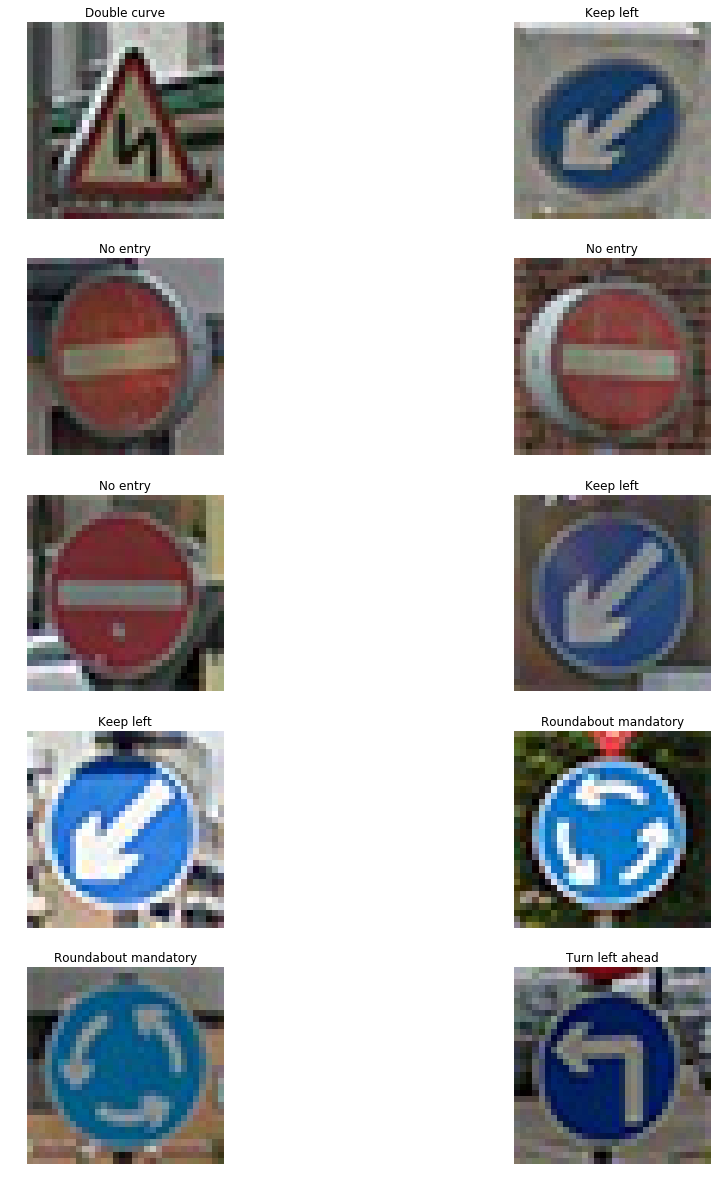

In [15]:
plt.figure(figsize=(16, 21))
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.imshow(test_imgs[i]) 
    plt.title(signs_class[np.argmax(prob, 1)[i]])
    plt.axis('off')
plt.show()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
We can see that 1 of traffic signs of presented in the training set classes were misclassified ("Road narrows on the right").Solution for this would be and more images of this class to make net more robust.
Final accuracy is 90% which is quite good.   

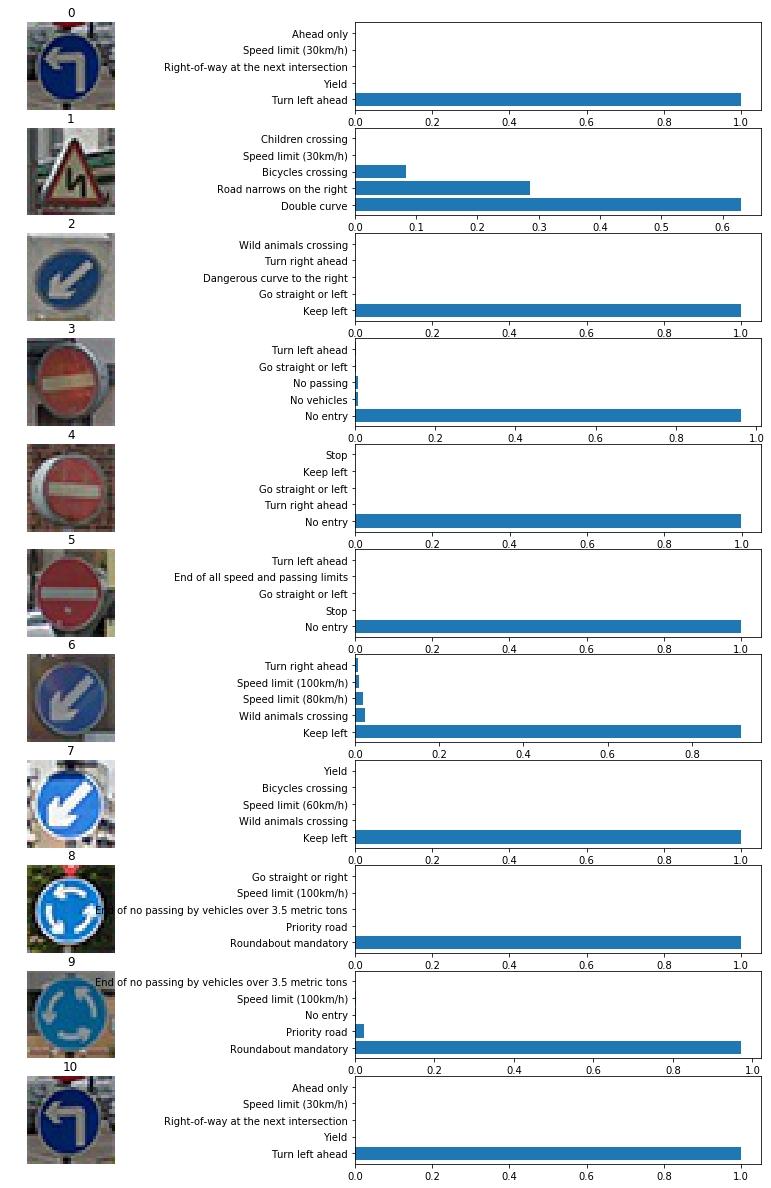

In [16]:
plt.figure(figsize=(16, 21))
for i in range(11):
    plt.subplot(11, 2, 2*i+1)
    plt.imshow(test_imgs[i-1]) 
    plt.title(i)
    plt.axis('off')
    plt.subplot(11, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), top_k.values[i-1, :])
    labs=[signs_class[j] for j in top_k.indices[i-1]]
    plt.yticks(np.arange(1, 6, 1), labs)
plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

In all cases except "Road narrows on th right" the predictor was very certain. Also in this case predictor misclassified image but correct prediction is in 2 place in top k so my first step in improving my network will be add more images of these class(apply more tranformations to make net more robust)  